In [1]:
# Install required libraries (only run once)
!pip install librosa #to load audio files
!pip install soundfile #works internally in librosa to read the audio
!pip install pandas numpy scikit-learn matplotlib seaborn

In [2]:
!pip install kagglehub

In [3]:
import kagglehub

# Downloads and caches dataset
path = kagglehub.dataset_download("chrisfilo/urbansound8k")

print("Dataset downloaded to:", path)

100%|██████████| 5.61G/5.61G [04:35<00:00, 21.9MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/chrisfilo/urbansound8k/versions/1


In [6]:
import pandas as pd
import os

# Correct path to CSV
metadata_path = "/root/.cache/kagglehub/datasets/chrisfilo/urbansound8k/versions/1/UrbanSound8K.csv"

# Load metadata
metadata = pd.read_csv(metadata_path)

# Show first few rows
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [7]:
# Select 6 sound classes
selected_classes = ['dog_bark', 'car_horn', 'drilling', 'siren', 'engine_idling', 'gun_shot']

# Filter metadata
filtered_meta = metadata[metadata['class'].isin(selected_classes)].reset_index(drop=True)

# Show the result
filtered_meta.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100648-1-0-0.wav,100648,4.823402,5.471927,2,10,1,car_horn
2,100648-1-1-0.wav,100648,8.998279,10.052132,2,10,1,car_horn
3,100648-1-2-0.wav,100648,16.699509,17.104837,2,10,1,car_horn
4,100648-1-3-0.wav,100648,17.631764,19.253075,2,10,1,car_horn


In [8]:
!pip install librosa

In [9]:
import librosa
import numpy as np

In [10]:
def extract_features(file_path):
    try:
        # Audio load karo (default sr=22050 Hz)
        y, sr = librosa.load(file_path, sr=None)

        # ZCR: kitni baar signal 0 ko cross karta hai
        zcr = np.mean(librosa.feature.zero_crossing_rate(y))

        # RMS energy: signal ki strength
        rms = np.mean(librosa.feature.rms(y=y))

        # STE: total energy (sum of squares)
        ste = np.sum(y ** 2) / len(y)

        # MFCCs (13 coefficients)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfccs_mean = np.mean(mfccs, axis=1)  # har coefficient ka mean

        # Spectral Centroid: brightness of sound
        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))

        # Spectral Bandwidth: width of spectrum
        spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))

        # Sab features combine karo
        features = [
            zcr, rms, ste,
            spectral_centroid, spectral_bandwidth,
            *mfccs_mean  # MFCCs spread out
        ]
        return features
    except Exception as e:
        print(f"Error: {e}")
        return None

In [11]:
import tqdm

features_list = []
labels = []

# Base audio folder path
audio_base_path = "/root/.cache/kagglehub/datasets/chrisfilo/urbansound8k/versions/1"

# Loop through each row of filtered metadata
for index, row in tqdm.tqdm(filtered_meta.iterrows(), total=len(filtered_meta)):
    fold = row['fold']
    file_name = row['slice_file_name']
    label = row['class']

    file_path = os.path.join(audio_base_path, f"fold{fold}", file_name)

    features = extract_features(file_path)
    if features:
        features_list.append(features)
        labels.append(label)

 36%|███▌      | 1684/4732 [02:12<02:47, 18.24it/s]/usr/local/lib/python3.11/dist-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
100%|██████████| 4732/4732 [05:03<00:00, 15.59it/s]


In [12]:
import pandas as pd

# Feature column names
feature_columns = [
    "ZCR", "RMS", "STE",
    "SpectralCentroid", "SpectralBandwidth"
] + [f"MFCC_{i+1}" for i in range(13)]

# Combine features and labels
df_features = pd.DataFrame(features_list, columns=feature_columns)
df_features['Label'] = labels

# Save to CSV
df_features.to_csv("urban_sound_features.csv", index=False)
print("Feature extraction complete and saved to CSV 🎉")

Feature extraction complete and saved to CSV 🎉


In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [15]:
# Load features
df = pd.read_csv("urban_sound_features.csv")

# Separate features (X) and labels (y)
X = df.drop("Label", axis=1)
y = df["Label"]

# Encode string labels to numbers
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Normalize features (important for distance-based models like KNN, SVM)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train-test (80-20)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)


🔹 Logistic Regression
               precision    recall  f1-score   support

     car_horn       0.72      0.51      0.60        86
     dog_bark       0.63      0.70      0.67       200
     drilling       0.72      0.78      0.75       200
engine_idling       0.66      0.77      0.71       200
     gun_shot       0.55      0.21      0.31        75
        siren       0.78      0.77      0.78       186

     accuracy                           0.69       947
    macro avg       0.68      0.62      0.63       947
 weighted avg       0.69      0.69      0.68       947



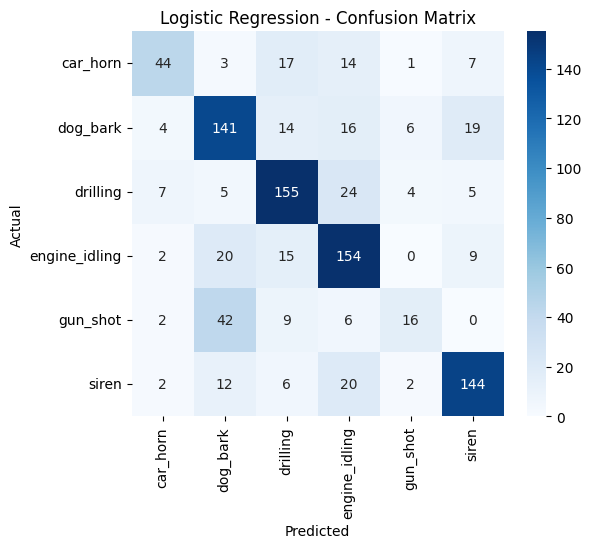


🔹 Random Forest
               precision    recall  f1-score   support

     car_horn       0.88      0.80      0.84        86
     dog_bark       0.82      0.87      0.84       200
     drilling       0.91      0.95      0.93       200
engine_idling       0.94      0.99      0.96       200
     gun_shot       0.98      0.60      0.74        75
        siren       0.93      0.95      0.94       186

     accuracy                           0.90       947
    macro avg       0.91      0.86      0.88       947
 weighted avg       0.90      0.90      0.90       947



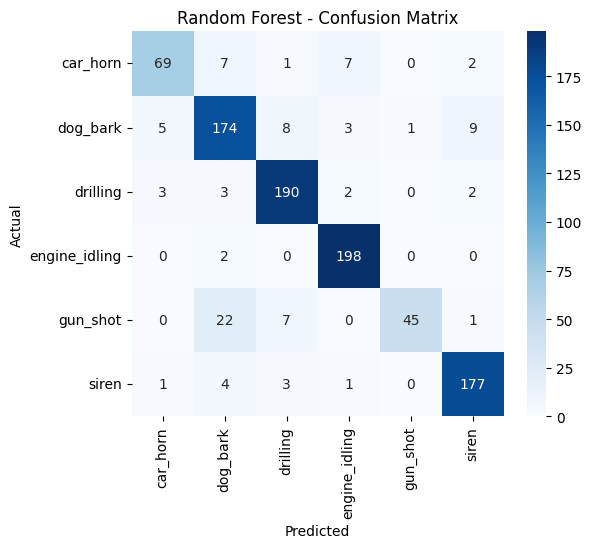


🔹 KNN
               precision    recall  f1-score   support

     car_horn       0.91      0.78      0.84        86
     dog_bark       0.86      0.80      0.83       200
     drilling       0.93      0.93      0.93       200
engine_idling       0.88      0.98      0.93       200
     gun_shot       0.74      0.73      0.74        75
        siren       0.93      0.95      0.94       186

     accuracy                           0.89       947
    macro avg       0.87      0.86      0.87       947
 weighted avg       0.89      0.89      0.89       947



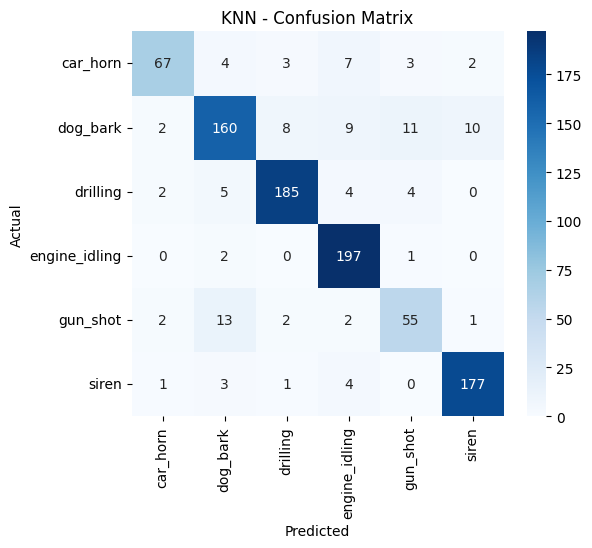


🔹 SVM
               precision    recall  f1-score   support

     car_horn       0.89      0.79      0.84        86
     dog_bark       0.76      0.81      0.78       200
     drilling       0.91      0.93      0.92       200
engine_idling       0.85      0.94      0.89       200
     gun_shot       0.83      0.52      0.64        75
        siren       0.90      0.91      0.90       186

     accuracy                           0.86       947
    macro avg       0.86      0.81      0.83       947
 weighted avg       0.86      0.86      0.85       947



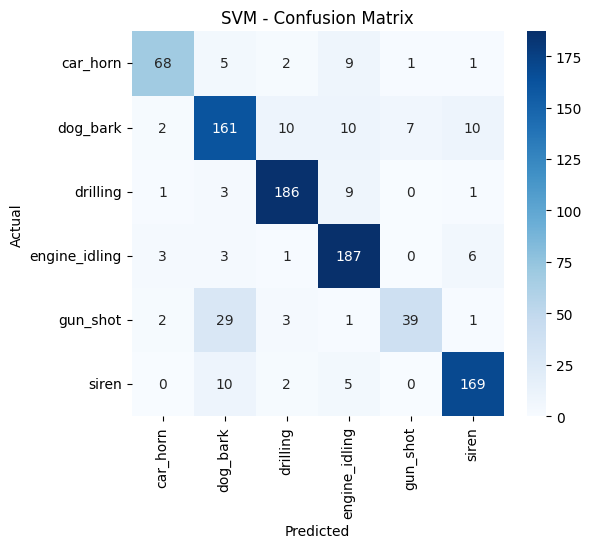

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Dictionary of models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC()
}

# Train and evaluate each model
for name, model in models.items():
    print(f"\n🔹 {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(classification_report(y_test, y_pred, target_names=le.classes_))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

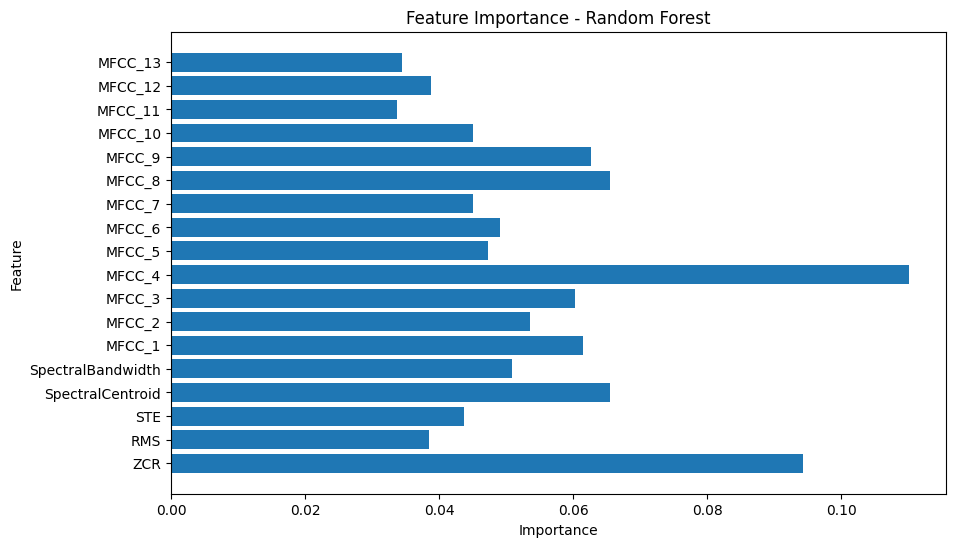

In [17]:
importances = models['Random Forest'].feature_importances_
feat_names = df.drop("Label", axis=1).columns

plt.figure(figsize=(10, 6))
plt.barh(feat_names, importances)
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

Why gun_shot low?
Sound duration short hoti hai

Similar to other sudden-loud sounds (car horn)

Class imbalance (only 75 samples)

Random forest outperformed every other model.


Audio needs more complex preprocessing

Features are harder to interpret

More sensitive to background sounds and quality

Random Forest outperforms other models on UrbanSound8K

MFCC, RMS, and spectral features are crucial

Gunshot is a difficult class → needs better features or more data

Audio classification needs deeper understanding of sound properties compared to image classification